In [4]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import gc
import os
from tqdm import tqdm
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 600)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data_path = ''
data_train = pd.read_csv(data_path+'sensor_train.csv')
data_test = pd.read_csv(data_path+'sensor_test.csv')
data_test['fragment_id'] += 10000
label = 'behavior_id'

In [5]:
data = pd.concat([data_train, data_test], sort=False)
df = data.drop_duplicates(subset=['fragment_id']).reset_index(drop=True)[['fragment_id', 'behavior_id']]

data['acc'] = (data['acc_x'] ** 2 + data['acc_y'] ** 2 + data['acc_z'] ** 2) ** 0.5
data['accg'] = (data['acc_xg'] ** 2 + data['acc_yg'] ** 2 + data['acc_zg'] ** 2) ** 0.5
data['xy'] = (data['acc_x'] ** 2 + data['acc_y'] ** 2 ) ** 0.5
data['xy_g'] = (data['acc_xg'] ** 2 + data['acc_yg'] ** 2) ** 0.5

for f in tqdm([f for f in data.columns if 'acc' in f]):
    for stat in ['min', 'max', 'mean', 'median', 'std', 'skew']:
        df[f+'_'+stat] = data.groupby('fragment_id')[f].agg(stat).values
        
train_df = df[df[label].isna()==False].reset_index(drop=True)
test_df = df[df[label].isna()==True].reset_index(drop=True)

drop_feat = []
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label] + drop_feat)]
print(len(used_feat))
print(used_feat)
scaler = MinMaxScaler()

train_x = train_df[used_feat]
train_y = train_df[label]
test_x = test_df[used_feat]

100%|██████████| 8/8 [00:17<00:00,  2.22s/it]


48
['acc_x_min', 'acc_x_max', 'acc_x_mean', 'acc_x_median', 'acc_x_std', 'acc_x_skew', 'acc_y_min', 'acc_y_max', 'acc_y_mean', 'acc_y_median', 'acc_y_std', 'acc_y_skew', 'acc_z_min', 'acc_z_max', 'acc_z_mean', 'acc_z_median', 'acc_z_std', 'acc_z_skew', 'acc_xg_min', 'acc_xg_max', 'acc_xg_mean', 'acc_xg_median', 'acc_xg_std', 'acc_xg_skew', 'acc_yg_min', 'acc_yg_max', 'acc_yg_mean', 'acc_yg_median', 'acc_yg_std', 'acc_yg_skew', 'acc_zg_min', 'acc_zg_max', 'acc_zg_mean', 'acc_zg_median', 'acc_zg_std', 'acc_zg_skew', 'acc_min', 'acc_max', 'acc_mean', 'acc_median', 'acc_std', 'acc_skew', 'accg_min', 'accg_max', 'accg_mean', 'accg_median', 'accg_std', 'accg_skew']


In [12]:
train_x.head()

,acc_max,acc_mean,acc_median,acc_min,acc_skew,acc_std,acc_x_max,acc_x_mean,acc_x_median,acc_x_min,acc_x_skew,acc_x_std,acc_xg_max,acc_xg_mean,acc_xg_median,acc_xg_min,acc_xg_skew,acc_xg_std,acc_y_max,acc_y_mean,acc_y_median,acc_y_min,acc_y_skew,acc_y_std,acc_yg_max,acc_yg_mean,acc_yg_median,acc_yg_min,acc_yg_skew,acc_yg_std,acc_z_max,acc_z_mean,acc_z_median,acc_z_min,acc_z_skew,acc_z_std,acc_zg_max,acc_zg_mean,acc_zg_median,acc_zg_min,acc_zg_skew,acc_zg_std,accg_max,accg_mean,accg_median,accg_min,accg_skew,accg_std,target
0,0.953939,0.281656,0.223607,0.000000,1.141795,0.225918,0.4,-0.001754,0.0,-0.9,-1.523203,0.194102,1.3,0.677193,0.7,-0.2,-0.909003,0.200016,0.2,-0.001754,-0.0,-0.3,-0.497876,0.085547,5.2,4.773684,4.8,4.4,0.284234,0.158707,0.7,0.003509,-0.0,-0.8,-0.283199,0.294573,9.3,8.508772,8.5,7.2,-0.746650,0.338738,10.560776,9.784581,9.786726,8.635392,-0.677138,0.293469,1.0
1,0.714143,0.186749,0.141421,0.000000,1.626938,0.147525,0.2,-0.025000,-0.0,-0.5,-1.350853,0.109959,1.0,0.678571,0.7,0.4,-0.199871,0.126080,0.2,0.026786,0.0,-0.1,0.434311,0.058748,5.1,4.830357,4.8,4.6,0.411559,0.123465,0.6,0.078571,0.1,-0.5,0.129004,0.184602,9.4,8.519643,8.5,8.1,0.917398,0.241525,10.521407,9.819616,9.791067,9.441398,1.053017,0.202188,1.0
2,1.513275,0.363894,0.244949,0.000000,1.890966,0.316852,0.7,-0.028070,-0.0,-0.5,0.489693,0.239609,1.8,0.792982,0.7,0.2,0.853589,0.339569,0.2,-0.005263,0.0,-0.6,-1.635879,0.136828,5.4,4.952632,4.9,4.4,-0.081638,0.234601,1.2,0.024561,0.0,-1.3,-0.770588,0.396989,9.8,8.394737,8.4,7.2,-0.103604,0.433186,10.813418,9.790638,9.827004,8.823831,-0.205059,0.355424,1.0
3,1.791647,0.400589,0.282843,0.000000,1.973559,0.373524,0.5,0.001818,0.0,-0.4,0.072280,0.178980,1.2,0.410909,0.4,-0.6,-0.555181,0.319532,0.4,0.023636,-0.0,-0.3,1.126930,0.121661,5.5,5.049091,5.0,4.5,-0.054651,0.196141,1.7,0.094545,0.0,-0.8,1.413450,0.496438,9.5,8.340000,8.3,7.5,0.472631,0.414371,10.585367,9.767121,9.780082,8.828363,0.193839,0.360655,1.0
4,1.886796,0.668420,0.547723,0.141421,1.136149,0.441521,0.9,0.001818,0.0,-1.3,-0.762639,0.338018,1.5,0.609091,0.7,-0.5,-0.127315,0.419114,0.6,0.003636,0.0,-0.5,0.464490,0.192415,5.3,4.645455,4.7,3.7,-0.382833,0.296784,1.8,0.023636,0.1,-1.7,-0.013071,0.705787,10.4,8.558182,8.6,5.8,-0.615809,0.753434,11.500435,9.778645,9.819878,7.856844,-0.043196,0.628718,1.0


In [11]:
features = [c for c in train_x.columns if c not in ['id', 'target']]

len_train = len(train_x)
train_x['target'] = 1
train_x = train_x.append(test_x).reset_index(drop = True)
train_x['target'] = train_x['target'].fillna(0)

In [18]:

random_state = 42
np.random.seed(random_state)
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
    "seed": random_state
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = train_x[[ 'target']]
oof['predict'] = 0
val_aucs = []


In [19]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_x, train_x['target'])):
    X_train, y_train = train_x.iloc[trn_idx][features], train_x.iloc[trn_idx]['target']
    X_valid, y_valid = train_x.iloc[val_idx][features], train_x.iloc[val_idx]['target']
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    evals_result = {}
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        7500,
                        valid_sets=[val_data],
                        early_stopping_rounds=100,
                        verbose_eval=50,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid[features], num_iteration=lgb_clf.best_iteration)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.877037
[100]	valid_0's auc: 0.892203
[150]	valid_0's auc: 0.898963
[200]	valid_0's auc: 0.900977
[250]	valid_0's auc: 0.902666
[300]	valid_0's auc: 0.90301
[350]	valid_0's auc: 0.904583
[400]	valid_0's auc: 0.904116
[450]	valid_0's auc: 0.904721
[500]	valid_0's auc: 0.904897
[550]	valid_0's auc: 0.90408
Early stopping, best iteration is:
[487]	valid_0's auc: 0.905101
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.881229
[100]	valid_0's auc: 0.892194
[150]	valid_0's auc: 0.896231
[200]	valid_0's auc: 0.900021
[250]	valid_0's auc: 0.901662
[300]	valid_0's auc: 0.90272
[350]	valid_0's auc: 0.903501
[400]	valid_0's auc: 0.903002
[450]	valid_0's auc: 0.90287
Early stopping, best iteration is:
[360]	valid_0's auc: 0.903858
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.872273
[100]	valid_0's auc: 0.88553
[150]	valid_0's auc: 0.892173
[2

In [20]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.898185054, std: 0.007417031. All auc: 0.898231212.


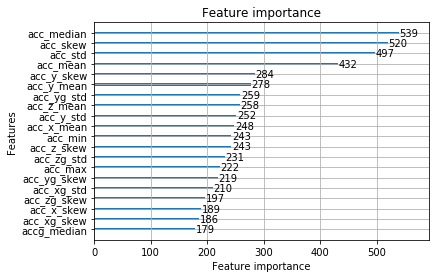

In [22]:
lgb.plot_importance(lgb_clf, max_num_features = 20)

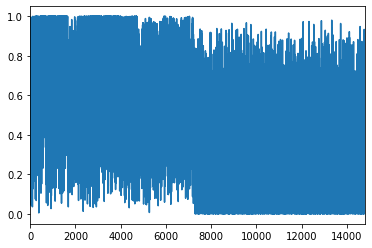

In [26]:

# Check distribution
oof['predict'].plot()

# Store to feather
#df_av_train[[ 'preds']].reset_index(drop=True).to_feather('adversarial_validation.ft')

In [28]:
oof['target'].value_counts()

0.0    7500
1.0    7292
Name: target, dtype: int64

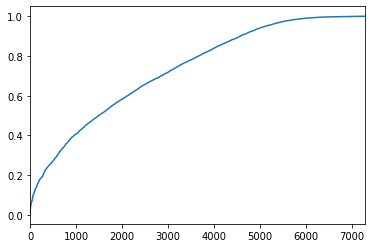

In [37]:
oof[oof['target']==1]['predict'].sort_values().reset_index(drop=True).plot()

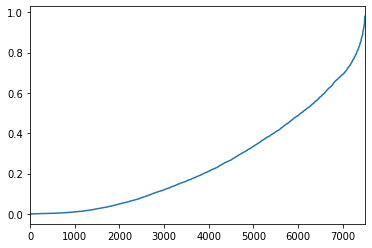

In [38]:
oof[oof['target']==0]['predict'].sort_values().reset_index(drop=True).plot()